<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Categorical-Encoding" data-toc-modified-id="Categorical-Encoding-1">Categorical Encoding</a></span></li><li><span><a href="#Feature-Scaling" data-toc-modified-id="Feature-Scaling-2">Feature Scaling</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-3">Model</a></span></li><li><span><a href="#Recursive-Feature-Elimination" data-toc-modified-id="Recursive-Feature-Elimination-4">Recursive Feature Elimination</a></span></li><li><span><a href="#Model-perf-numbers" data-toc-modified-id="Model-perf-numbers-5">Model perf numbers</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from category_encoders import CatBoostEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from matplotlib import style
from sklearn.metrics import roc_curve, auc

In [2]:
df = pd.read_csv('../dataset/data.csv')

In [3]:
y = df['target']
df.drop('target', axis = 1, inplace = True)

In [4]:
perm = np.random.permutation(len(df)) 
train = df.iloc[perm].reset_index(drop=True) 
y = y.iloc[perm].reset_index(drop=True)

In [5]:
train.drop(['track_name', 'track_id'], axis = 1, inplace = True)

In [6]:
train.head()

,artist,album,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Shankar-Ehsaan-Loy,Zindagi Na Milegi Dobara,57,0.517,0.565,9,-10.184,1,0.0441,0.7210,0.006890,0.0997,0.690,169.952,251704,4
1,Yo Yo Honey Singh,Yo Yo Honey Singh Is Back,47,0.663,0.938,0,-2.894,0,0.0335,0.0102,0.000009,0.7500,0.551,127.988,243206,4
2,The Flight,Assassin's Creed Odyssey (Original Game Soundt...,29,0.258,0.113,2,-14.494,1,0.0377,0.8940,0.405000,0.1180,0.106,95.984,94689,3
3,Krsna Solo,Tanu Weds Manu,64,0.726,0.994,5,-2.433,0,0.0543,0.0210,0.010800,0.2220,0.779,129.989,264900,4
4,Various Artists,Karwaan,57,0.693,0.518,1,-9.146,1,0.0282,0.6530,0.531000,0.1380,0.374,128.041,266042,4


### Categorical Encoding

In [7]:
cbe = CatBoostEncoder(cols = ['artist', 'album'])
cbe.fit(train, y)
train = cbe.transform(train)

C:\Users\blahb\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


### Feature Scaling

In [8]:
scaler = MinMaxScaler().fit(train)
train = scaler.transform(train)

### Model

In [9]:
rf_model = pickle.load(open('../saved_models/random_forest_grid_model.pkl', 'rb'))

In [10]:
new_model = RandomForestClassifier(criterion = rf_model.best_params_['criterion'],
                                  min_impurity_decrease = rf_model.best_params_['min_impurity_decrease'],
                                  min_samples_leaf = rf_model.best_params_['min_samples_leaf'],
                                  min_samples_split = rf_model.best_params_['min_samples_split'],
                                  n_estimators = rf_model.best_params_['n_estimators'],
                                  )

### Recursive Feature Elimination

In [11]:
from sklearn.feature_selection import RFE

In [12]:
rfe = RFE(new_model, step = 1, verbose = 2)
x_red = rfe.fit_transform(train, y)
new_model.fit(x_red, y)
print("Model Accuracy: ", round(new_model.score(x_red, y), 2))

Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Model Accuracy:  0.83


In [13]:
columns = df.drop(['track_name', 'track_id'], axis = 1).columns

In [14]:
columns = columns[rfe.get_support()]

In [15]:
pickle.dump(new_model, open("../saved_models/final_rf.pkl", 'wb'))

In [16]:
feature_importances = {columns[i]:rf_model.best_estimator_.feature_importances_[i]*100 for i in range(len(columns))}
feature_importances = pd.Series(feature_importances).sort_values(ascending = False)

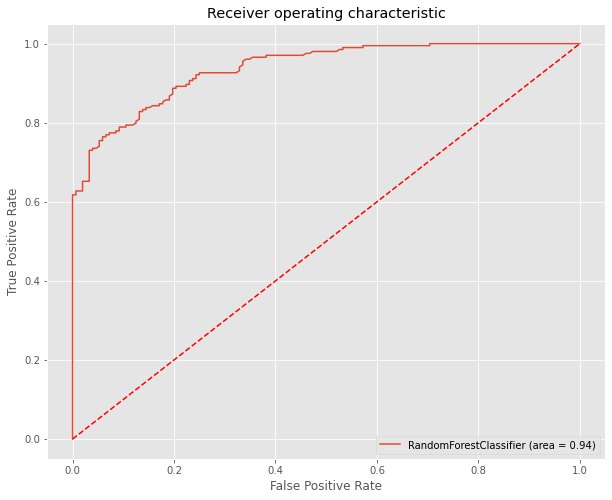

In [22]:
probs = new_model.predict_proba(x_red)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y, preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (10, 8))
plt.plot(fpr, tpr, label='RandomForestClassifier (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
style.use("ggplot")
plt.savefig('14.png')
plt.show()

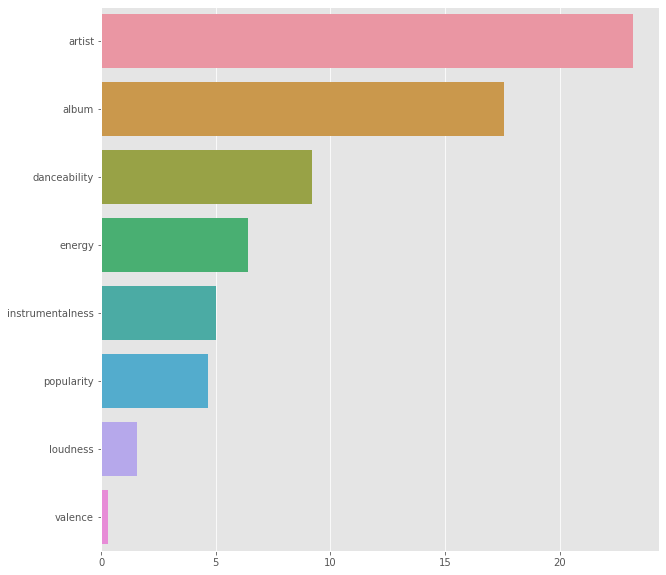

In [18]:
plt.figure(figsize = (10, 10))
sns.barplot(y = feature_importances.index, x = feature_importances.values, orient = 'h', )
style.use("ggplot")
plt.savefig('13.png')
plt.show()

### Model perf numbers

In [19]:
y_score = new_model.predict(x_red)

In [20]:
print("AUC_ROC: ", metrics.roc_auc_score(y, y_score))

AUC_ROC:  0.8419762641898865


In [21]:
print(metrics.classification_report(y, y_score))

              precision    recall  f1-score   support

           0       0.76      0.89      0.82       152
           1       0.91      0.79      0.85       204

    accuracy                           0.83       356
   macro avg       0.83      0.84      0.83       356
weighted avg       0.85      0.83      0.84       356

